In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

main_audio_path = '/content/drive/My Drive/Maestría/3er_Semestre/Deep_Learning/Proyecto_Final/'

Load and Exploratory Analysis

In [3]:
file_list = []
vocal_channel_list = []
emotion_list = []
emotional_intensity_list = []
statement_list = []
repetition_list = []
actor_list = []
actor_sex_list = []

vocal_channel_description = ["speech", "song"]
emotion_description = ["neutral", "calm",  "happy", "sad", "angry", "fearful",  "disgust", "surprised"]
emotional_intensity_description = [ "normal", "strong"]

for subdir, dirs, files in os.walk(main_audio_path):
    for file in files:
        if file.endswith(".wav") and "(1)" not in file:
          no_extension = file.split(".")[0]
          name_splitted = no_extension.split("-")
          file_list.append(os.path.join(subdir, file))
          vocal_channel_list.append(vocal_channel_description[int(name_splitted[1]) - 1])
          emotion_list.append(emotion_description[int(name_splitted[2]) - 1])
          emotional_intensity_list.append(emotional_intensity_description[int(name_splitted[3]) - 1])
          statement_list.append(name_splitted[4])
          repetition_list.append(name_splitted[5])
          actor_list.append(name_splitted[6])
          actor_sex_list.append("Female") if int(name_splitted[6]) % 2 == 0 else actor_sex_list.append("Male")

d = {"file_name": file_list, "vocal_channel": vocal_channel_list, "emotion" : emotion_list, \
     "emotional_intensity": emotional_intensity_list, "statement":statement_list, \
     "repetition":repetition_list, "actor":actor_list, "actor_sex":actor_sex_list}

df = pd.DataFrame(data = d)

In [ ]:
df.to_csv(main_audio_path + 'df_processed_main.csv')
df.head()

In [3]:
df = pd.read_csv(main_audio_path + "df_processed_main.csv", index_col=0)
df.head()

,file_name,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,actor_sex
0,/content/drive/My Drive/Maestría/3er_Semestre/...,speech,neutral,normal,2,2,2,Female
1,/content/drive/My Drive/Maestría/3er_Semestre/...,speech,neutral,normal,1,2,2,Female
2,/content/drive/My Drive/Maestría/3er_Semestre/...,speech,calm,strong,1,2,2,Female
3,/content/drive/My Drive/Maestría/3er_Semestre/...,speech,calm,normal,2,2,2,Female
4,/content/drive/My Drive/Maestría/3er_Semestre/...,speech,calm,strong,1,1,2,Female


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1439
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   file_name            1440 non-null   object
 1   vocal_channel        1440 non-null   object
 2   emotion              1440 non-null   object
 3   emotional_intensity  1440 non-null   object
 4   statement            1440 non-null   int64 
 5   repetition           1440 non-null   int64 
 6   actor                1440 non-null   int64 
 7   actor_sex            1440 non-null   object
dtypes: int64(3), object(5)
memory usage: 101.2+ KB


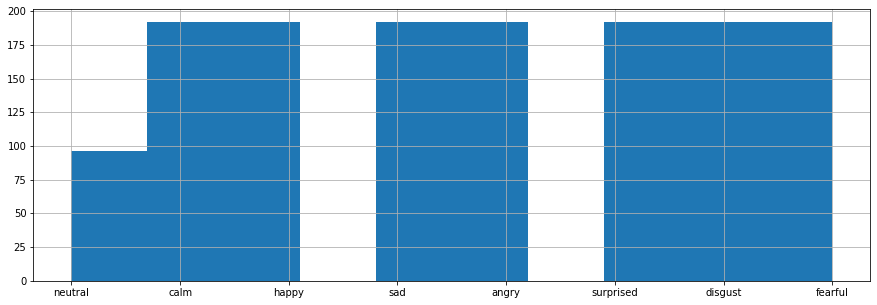

In [ ]:
df["emotion"].hist(figsize=(15, 5))

In [10]:
df["emotion"].value_counts()

fearful      192
calm         192
happy        192
disgust      192
angry        192
surprised    192
sad          192
neutral       96
Name: emotion, dtype: int64

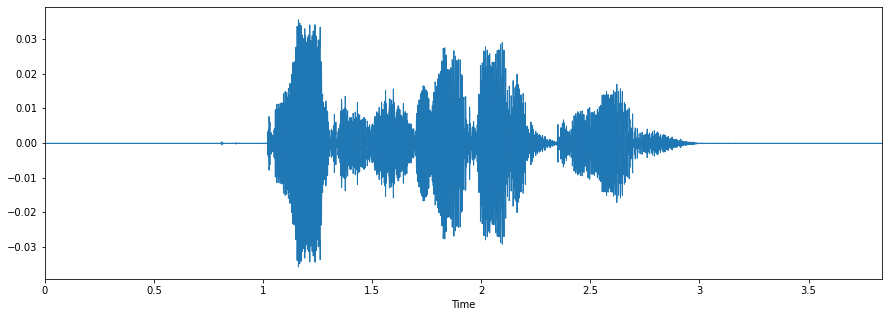

In [11]:
example = main_audio_path + "/Actor_01/03-01-07-01-02-02-01.wav"
data, sampling_rate = librosa.load(example)
#signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [12]:
ipd.Audio(example)

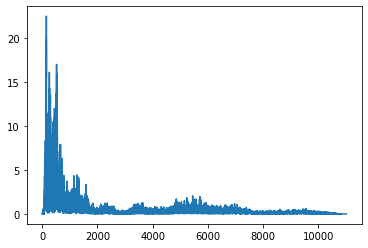

In [ ]:
fft = np.fft.fft(data)
magnitude = np.abs(fft)
frequencies = np.linspace(0, sampling_rate, len(magnitude))
left_frequencies = frequencies[:int(len(frequencies)/2)]
left_magnitude = magnitude[:int(len(frequencies)/2)]
plt.plot(left_frequencies, left_magnitude);

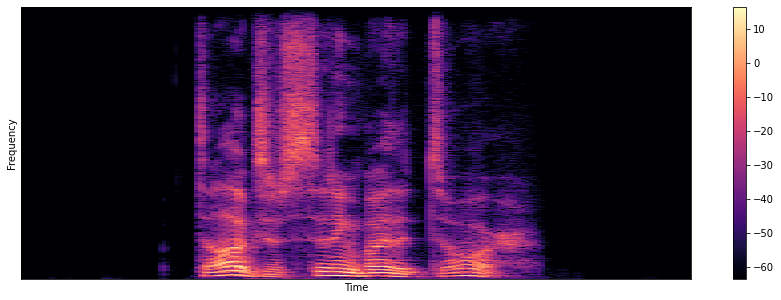

In [ ]:
n_sample_fft = 2048 #Number of samples , window for a single FFT
hop_length = 512 #Number of samples, amount we are shifting to the right the FFT

stft = librosa.core.stft(data, hop_length = hop_length, n_fft = n_sample_fft)
spectrogram = np.abs(stft)
plt.figure(figsize=(15, 5))
log_spectrogram = librosa.amplitude_to_db(spectrogram) # magnitud en decibeles
librosa.display.specshow(log_spectrogram, sr = sampling_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

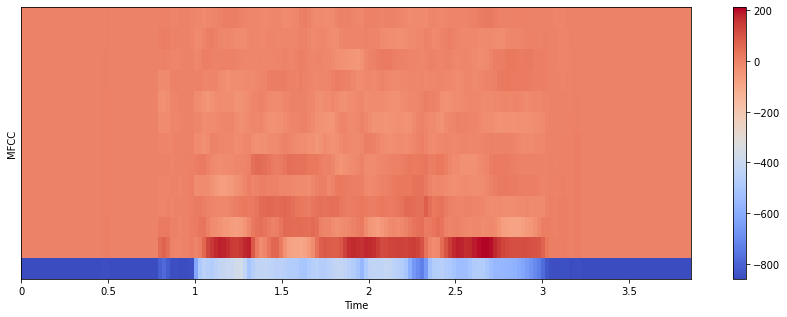

In [ ]:
# MFCC
mfcc = librosa.feature.mfcc(y=data, sr=sampling_rate, n_fft = n_sample_fft, hop_length= hop_length, n_mfcc=13) #n_mfcc = number of coefficients normally used 13
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

Preprocessing Data

In [4]:
def add_mfcc(file_name):
  audio_data, sample_rate = librosa.load(file_name)
  mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=13)
  return mfcc
df["mfcc"] = df["file_name"].apply(add_mfcc)

In [73]:
# shapes = df['mfcc'].apply(lambda x: x.shape[1])
# shapes = shapes.to_list()
# max_shape = np.max(shapes)
# print(max_shape)
# df['mfcc_padding'] = df['mfcc'].apply(lambda x: np.hstack([x, np.zeros([13, max_shape - x.shape[1]])]) if max_shape > x.shape[1] else x)

228


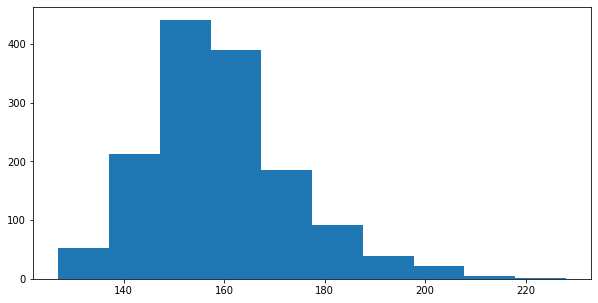

In [19]:
plt.figure(figsize=(10,5))
plt.hist(shapes);

In [5]:
max_shape = 180
df['mfcc_padding_less'] = df['mfcc'].apply(lambda x: np.hstack([x, np.zeros([13, max_shape - x.shape[1]])]) if max_shape > x.shape[1] else x[:,:max_shape])

In [6]:
df_reduced = df[['emotion', 'mfcc_padding_less']]
df_reduced.columns

Index(['emotion', 'mfcc_padding_less'], dtype='object')

In [7]:
df_reduced['emotion'].value_counts()

fearful      192
angry        192
disgust      192
sad          192
surprised    192
calm         192
happy        192
neutral       96
Name: emotion, dtype: int64

In [8]:
encoder = LabelEncoder()
df_reduced = df_reduced.assign(emotion=encoder.fit_transform(df_reduced.emotion))
df_reduced['emotion'].value_counts()
# df.to_csv(main_audio_path + 'training_data_mfcc.csv') #This will be the best to load...

7    192
6    192
4    192
3    192
2    192
1    192
0    192
5     96
Name: emotion, dtype: int64

In [91]:
encoder.classes_.tolist

<function ndarray.tolist>

In [9]:
X = df_reduced.drop(['emotion'], axis = 1)
Y = df_reduced['emotion']

In [10]:
def normalize(x):
  # x = x.T
  mean = np.mean(x.flatten())
  std_dev = np.std(x.flatten())
  new = (x - mean)/std_dev
  normalized_list.append(new)

In [11]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(X, Y):
  x_train = X.loc[train_index]
  y_train = Y.loc[train_index]
  x_test = X.loc[test_index]
  y_test = Y.loc[test_index]

In [12]:
x_train['mfcc_padding_less'][0].shape

(13, 180)

In [13]:
normalized_list = []
x_train['mfcc_padding_less'].apply(normalize)
x_train = np.array(normalized_list)
x_train.shape

(1152, 13, 180)

In [14]:
normalized_list = []
x_test['mfcc_padding_less'].apply(normalize)
x_test = np.array(normalized_list)
x_test.shape

(288, 13, 180)

Add new axis for number of dimensios in a CNN

In [15]:
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
print(x_train.shape)
print(x_test.shape)

(1152, 13, 180, 1)
(288, 13, 180, 1)


In [16]:
y_train = np.array(y_train.to_list())
y_train

array([4, 2, 7, ..., 6, 0, 4])

In [17]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models


In [18]:
n_outputs = len(df['emotion'].unique())
input_shape = (x_train.shape[1], x_train.shape[2], 1) # 1: Depth

Modelo Inicial

In [68]:
model = models.Sequential()
model.add(layers.Conv2D(32, 3, activation = 'relu', input_shape = input_shape)) #128
model.add(layers.MaxPool2D(3, 3))
model.add(layers.Conv2D(32, 2, activation = 'relu', padding = 'same')) #64
model.add(layers.MaxPool2D(3, 3))
model.add(layers.Conv2D(16, 2, activation = 'relu', padding = 'same')) #64
model.add(layers.Flatten())
model.add(layers.Dense(64, activation ='relu'))
model.add(layers.Dense(n_outputs, activation ='softmax'))
model.summary()
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=["accuracy"]) #SparseCategoricalCrossentropy, categorical_crossentropy

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 11, 178, 32)       320       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 3, 59, 32)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 3, 59, 32)         4128      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 1, 19, 32)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 1, 19, 16)         2064      
_________________________________________________________________
flatten_17 (Flatten)         (None, 304)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 64)              

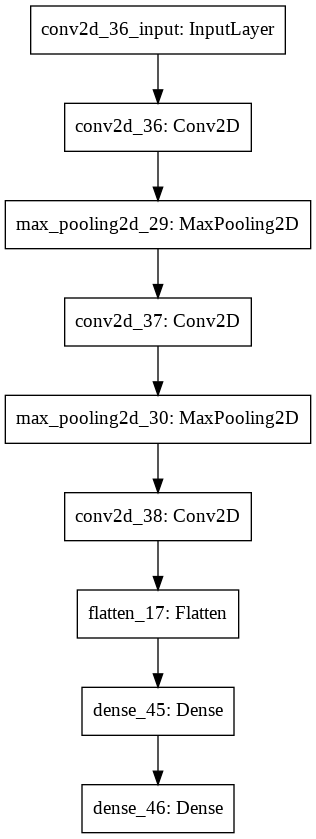

In [69]:
tf.keras.utils.plot_model(model)

Modelo Final

In [53]:
model8 = models.Sequential()
model8.add(layers.Conv2D(128, 3, activation = 'relu', input_shape = input_shape)) #128
model8.add(layers.MaxPool2D(3, 3))
model8.add(layers.Dropout(0.3)) #0.3
model8.add(layers.Conv2D(64, 2, activation = 'relu', padding = 'same')) #64
model8.add(layers.MaxPool2D(3, 3))
model8.add(layers.Dropout(0.3)) #0.3
model8.add(layers.Flatten())
model8.add(layers.Dense(128, activation ='relu'))
model8.add(layers.Dropout(0.3))
model8.add(layers.Dense(64, activation ='relu'))
model8.add(layers.Dropout(0.3))
model8.add(layers.Dense(n_outputs, activation ='softmax'))
model8.summary()
model8.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=["accuracy"]) #SparseCategoricalCrossentropy, categorical_crossentropy


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 11, 178, 128)      1280      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 59, 128)        0         
_________________________________________________________________
dropout_51 (Dropout)         (None, 3, 59, 128)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 3, 59, 64)         32832     
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 1, 19, 64)         0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 1, 19, 64)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 1216)            

In [54]:
history1 = model8.fit(x_train, y_train, epochs = 200, validation_data = (x_test, y_test))

Epoch 1/200
36/36 [==============================] - 4s 114ms/step - loss: 2.0810 - accuracy: 0.1424 - val_loss: 2.0654 - val_accuracy: 0.1458
Epoch 2/200
36/36 [==============================] - 4s 111ms/step - loss: 2.0482 - accuracy: 0.1536 - val_loss: 2.0246 - val_accuracy: 0.2049
Epoch 3/200
36/36 [==============================] - 4s 111ms/step - loss: 1.9721 - accuracy: 0.2057 - val_loss: 1.9051 - val_accuracy: 0.2257
Epoch 4/200
36/36 [==============================] - 4s 110ms/step - loss: 1.8587 - accuracy: 0.2674 - val_loss: 1.7885 - val_accuracy: 0.2882
Epoch 5/200
36/36 [==============================] - 4s 110ms/step - loss: 1.7372 - accuracy: 0.3194 - val_loss: 1.7342 - val_accuracy: 0.3264
Epoch 6/200
36/36 [==============================] - 4s 110ms/step - loss: 1.7117 - accuracy: 0.3411 - val_loss: 1.7147 - val_accuracy: 0.3264
Epoch 7/200
36/36 [==============================] - 4s 109ms/step - loss: 1.7081 - accuracy: 0.3247 - val_loss: 1.7099 - val_accuracy: 0.3056

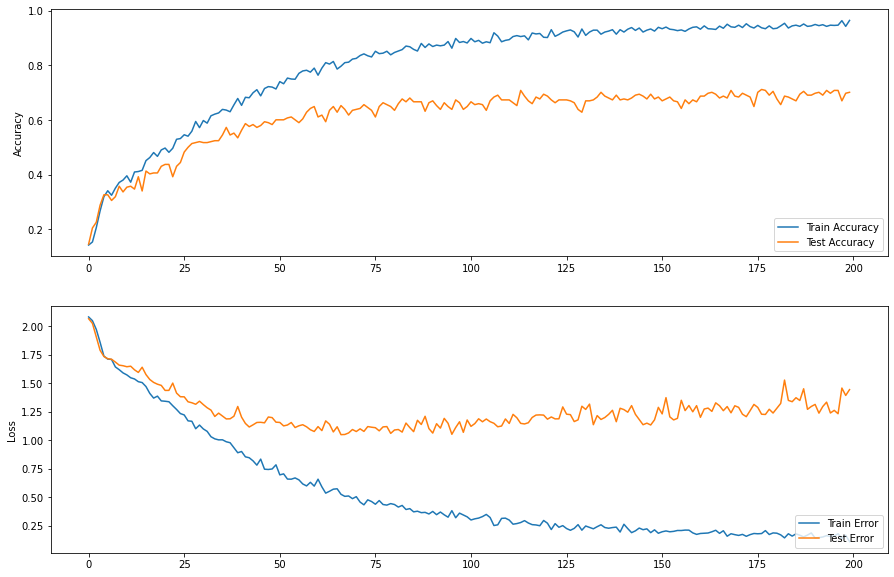

In [57]:
fig, axs = plt.subplots(2)
fig.set_figwidth(15)
fig.set_figheight(10)
axs[0].plot(history1.history["accuracy"], label = "Train Accuracy")
axs[0].plot(history1.history["val_accuracy"], label = "Test Accuracy")
axs[0].set_ylabel("Accuracy")
axs[0].legend(loc="lower right")

axs[1].plot(history1.history["loss"], label = "Train Error")
axs[1].plot(history1.history["val_loss"], label = "Test Error")
axs[1].set_ylabel("Loss")
axs[1].legend(loc="lower right")

In [64]:
model8.save(main_audio_path + 'audio_model.h5')
history_df = pd.DataFrame(history1.history)
with open(main_audio_path + 'model_history.csv', mode = 'w') as h:
  history_df.to_csv(h)

In [72]:
pred = model1.predict(x_test)
pred = pred.argmax(axis=1)
pred = pred.astype(int).flatten()
pred = encoder.inverse_transform(pred)

In [77]:
actual = np.array(y_test)

In [80]:
actual = actual.astype(int).flatten()
actual = encoder.inverse_transform(actual)

In [100]:
class_names = encoder.classes_.tolist()
class_names

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [82]:
prediction_df = pd.DataFrame({"Prediction":pred,"Actual":actual},index=class_names)
prediction_df.head()

,Prediction,Actual
0,neutral,sad
1,neutral,calm
2,angry,happy
3,angry,angry
4,neutral,neutral


In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

In [99]:
print(accuracy_score(actual, pred))

0.7013888888888888


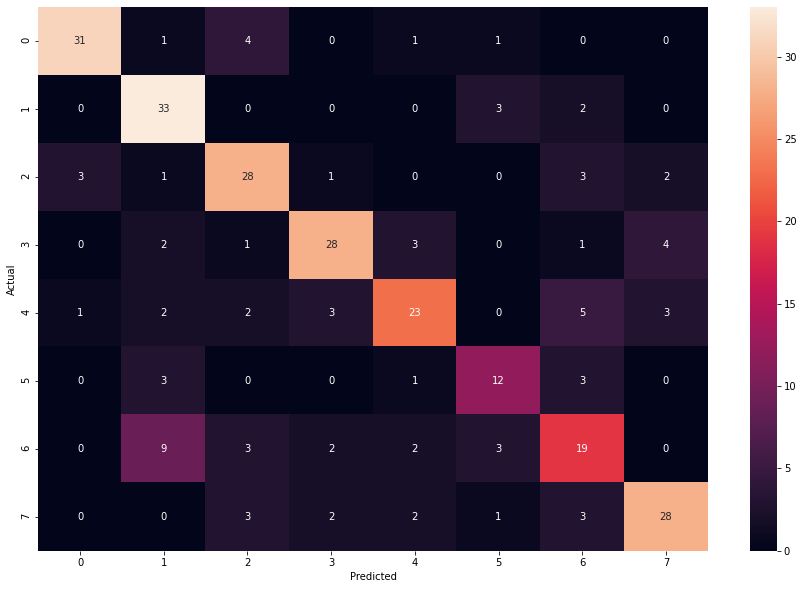

In [104]:
cm = confusion_matrix(actual,pred)
plt.figure(figsize=(15,10))

sns.heatmap(cm, annot=True);
plt.ylabel('Actual');
plt.xlabel('Predicted');

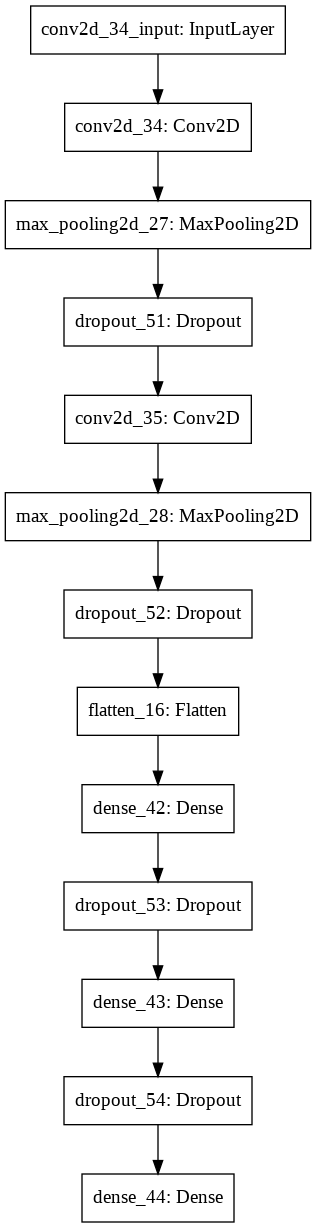

In [63]:
tf.keras.utils.plot_model(model1)